In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import os
import sys

import fitsio
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.table import Table
import healpy as hp
from healpy.newvisufunc import projview
import pymaster as nmt

#sys.path.insert(0, '/home/aew492/lss-dipoles')
#sys.path.insert(0, '/home/investigator/code/lss-dipoles')
sys.path.insert(0, '..')
import tools
from qso_sample import QSOSample
import dipole
import ellisbaldwin
import multipoles
from jackknife import get_longitude_subsamples_from_hpmap, compute_jackknife_uncertainty, covar_jackknife

In [3]:
import matplotlib
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['legend.fontsize'] = 16

matplotlib.rc('text', usetex=True)

In [4]:
basedir = '../../quasar_data_abby/catalogs'

In [5]:
color_quaia = 'mediumvioletred'
color_catwise = 'teal'
lw = 2
lw_grid = 0.5

### functions

In [6]:
def C_1(dipole_amplitude):  # from the new Abghari et al. (including Douglas Scott), eq. 3.3
    # return dipole_amplitude**2 / 3
    return 4 * np.pi / 9 * dipole_amplitude**2

def D(C_1):
    return np.sqrt(C_1) * 9 / (4 * np.pi)

In [7]:
# define function for jackknife: output needs to be just the Cells, to compute the uncertainty
def Cells_for_jk(overdensity_map, Wmask, max_ell, selfunc=None):
    ells, Cells = multipoles.compute_Cells_in_overdensity_map(overdensity_map, Wmask, max_ell, selfunc=selfunc)
    return Cells

### load samples and construct overdensity maps

In [8]:
# some key variables !!

# ABBY
#catdir = '/scratch/aew492/quasars/catalogs'
#selfuncdir_quaia = os.path.join(catdir, 'quaia/selfuncs')
#selfuncdir_catwise = os.path.join(catdir, 'catwise_agns/selfuncs')

# KSF
catdir =  '../../quasar_data_abby/catalogs'
selfuncdir_quaia = '../../gaia-quasars-lss/data/maps/'
selfuncdir_catwise = '../../gaia-quasars-lss/data/maps/'

mask_fn = os.path.join(catdir, 'masks/mask_master_hpx_r1.0.fits')
Wmask = 0.1  # fiducial regularization
max_ell = 8  # max ell to fit

#### CatWISE

In [9]:
# instantiate dipole object:
d = QSOSample(initial_catfn=os.path.join(catdir, 'catwise_agns/catwise_agns_master.fits'),
              mask_fn=mask_fn,
              mag='W1', maglim=16.4,
              basedir=basedir,
              blim=30)
d.cut_galactic_plane()  # cuts all sources with |b|<blim from the working source table

# get the expected dipole amplitude (before we make the magnitude cut at maglim, so we can compute the number-count slope)
expected_dipamp_catwise = ellisbaldwin.compute_expected_dipole_wise(d.table, maglimit=d.maglim,
                                                            min_w1=16., max_w1=16.5)  # reasonable min and max around the magnitude limit
d.cut_mag()  # now we cut all sources fainter than the input magnitude limit

loading initial catalog, ../../quasar_data_abby/catalogs/catwise_agns/catwise_agns_master.fits
8532854 sources in initial catalog.
cut |b| <= 30 -> 4479160 sources left.
computing expected dipole from Ellis-Baldwin:
	number-count slope x = 1.748
	effective alpha = 1.270
	expected dipole amplitude = 0.0074
cut W1 > 16.4 -> 1400045 sources left.


In [10]:
# at the healpix level:

# load selection function
# selfunc_catwise = d.get_selfunc(os.path.join(catdir, 'catwise_agns/selfuncs',
#                                             f'selection_function_NSIDE{d.NSIDE}_catwise_pluszodis.fits'))
selfunc_catwise = d.get_selfunc(os.path.join(selfuncdir_catwise,
                                            f'selection_function_NSIDE{d.NSIDE}_catwise_pluszodis.fits'))

# construct overdensity map with no selection function
overdensity_map_catwise = d.construct_overdensity_map(selfunc=None)

# and with the selection function
overdensity_map_sf_catwise = d.construct_overdensity_map(selfunc=selfunc_catwise)

constructing overdensity map
selection function not provided; assuming completeness = 1 in every pixel
defining healpix mask...
	masked pixels |b|<30deg, from mask_fn, and where completeness < 0.5
constructing overdensity map


In [11]:
# for CatWISE, we also want to correct for a density trend in ecliptic latitude, to match Secrest:
# get the ecliptic latitudes of each healpixel
lon, lat = hp.pix2ang(d.NSIDE, np.arange(hp.nside2npix(d.NSIDE)), lonlat=True)
elat = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').geocentrictrueecliptic.lat

# construct the masked datamap
masked_datamap = d.construct_masked_datamap(selfunc=None, return_map=True)

# fit a line: density vs elat
idx = ~np.isnan(elat) & ~np.isnan(masked_datamap)
p = np.polyfit(np.abs(elat)[idx], masked_datamap[idx], deg=1)
# correct the densities and fit to the corrected densities
map_elatcorr = masked_datamap - np.polyval(p, np.abs(elat.value)) + p[1]
p_corr = np.polyfit(np.abs(elat)[idx], map_elatcorr[idx], deg=1) # in case we want to check the corrected trend
# then the overdensity map is
overdensity_map_elat_catwise = map_elatcorr / np.nanmean(map_elatcorr) - 1

selection function not provided; assuming completeness = 1 in every pixel


#### Quaia

In [67]:
# instantiate dipole object:
d = QSOSample(initial_catfn=os.path.join(catdir, 'quaia/quaia_G20.5.fits'),
              mask_fn=mask_fn,
              mag='g', maglim=20.,
              blim=30)
d.cut_galactic_plane()  # cuts all sources with |b|<blim from the working source table

# get the expected dipole amplitude (before we make the magnitude cut at maglim, so we can compute the number-count slope)
expected_dipamp_quaia = ellisbaldwin.compute_expected_dipole_gaia(d.table, maglimit=d.maglim,
                                                            min_g=19.5, max_g=20.5)  # reasonable min and max around the magnitude limit
d.cut_mag()  # now we cut all sources fainter than the input magnitude limit

loading initial catalog, ../../quasar_data_abby/catalogs/quaia/quaia_G20.5.fits
1295502 sources in initial catalog.
cut |b| <= 30 -> 917566 sources left.
computing expected dipole from Ellis-Baldwin:
	number-count slope x = 1.309
	effective alpha = 0.713
	expected dipole amplitude = 0.0052
cut G > 20.0 -> 530364 sources left.


In [72]:
# at the healpix level:

# load selection function
selfunc_quaia = d.get_selfunc(os.path.join(selfuncdir_quaia,
                                            f'selection_function_NSIDE{d.NSIDE}_G{d.maglim}.fits'))
# overdensity map, corrected by selection function
#min_completeness = 0.5
min_completeness = 0
overdensity_map_sf_quaia = d.construct_overdensity_map(selfunc=selfunc_quaia,
                                                            min_completeness=min_completeness #default 0.5
                                                            )

# overdensity map, NOT corrected by selection function
overdensity_map_quaia = d.construct_overdensity_map(selfunc=None)

constructing overdensity map
defining healpix mask...
	masked pixels |b|<30deg, from mask_fn, and where completeness < 0
constructing overdensity map
selection function not provided; assuming completeness = 1 in every pixel
defining healpix mask...
	masked pixels |b|<30deg, from mask_fn, and where completeness < 0.5


[autoreload of qso_sample failed: Traceback (most recent call last):
  File "/home/investigator/miniconda3/envs/gaiaenv/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/investigator/miniconda3/envs/gaiaenv/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/investigator/miniconda3/envs/gaiaenv/lib/python3.12/importlib/__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 991, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1129, in get_code
  File "<frozen importlib._bootstrap_external>", line 1059, in source_to_code
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/home/investigator/code/lss-dipoles/noteb

In [70]:
# oy why are these note exactly the same...
np.sum(d.mask & (selfunc_quaia > min_completeness)), np.sum(d.mask)

(23559, 23562)

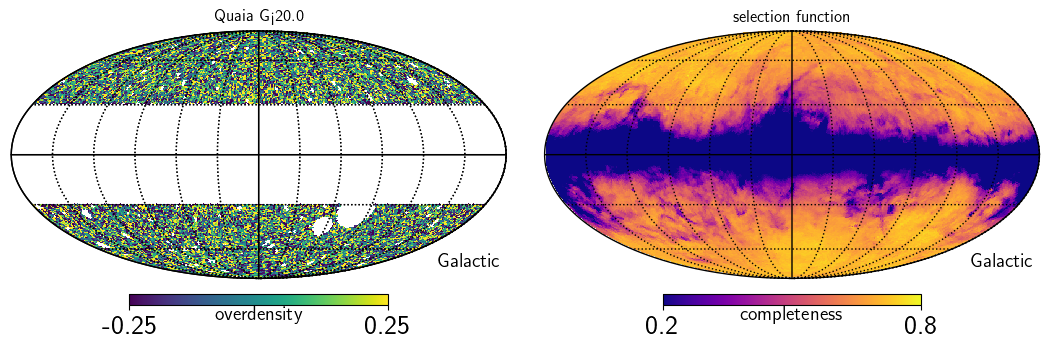

In [14]:
# plot
fig = plt.figure(figsize=(16,3))
hp.mollview(overdensity_map_sf_quaia, coord=['C','G'], min=-0.25, max=0.25, badcolor='w', fig=fig, sub=(1,3,1),
            unit='overdensity', title=f'Quaia G<{d.maglim}')
hp.graticule()
hp.mollview(selfunc_quaia, coord=['C','G'], min=0.2, max=0.8, badcolor='w', fig=fig, sub=(1,3,2), cmap='plasma',
            unit='completeness', title=f'selection function')
hp.graticule()

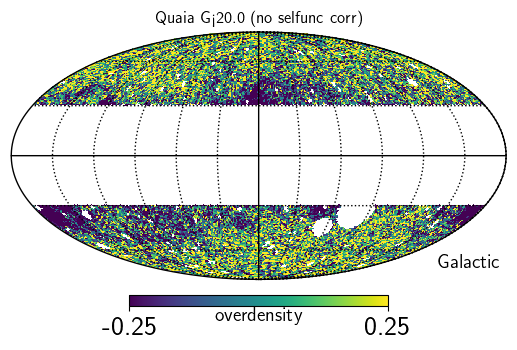

In [15]:
fig = plt.figure(figsize=(16,3))
hp.mollview(overdensity_map_quaia, coord=['C','G'], min=-0.25, max=0.25, badcolor='w', fig=fig, sub=(1,3,1),
            unit='overdensity', title=f'Quaia G<{d.maglim} (no selfunc corr)')
hp.graticule()

# C_ells direct

In [16]:
# Quaia
ells, Cells_quaia = multipoles.compute_Cells_in_overdensity_map(overdensity_map_sf_quaia,
                                                          Wmask=Wmask, max_ell=max_ell, selfunc=selfunc_quaia)

In [17]:
ells

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [18]:
save_dir = '../../quasar_data_abby/jackknife'
Cells_quaia_std = np.load(os.path.join(save_dir, f'jk_Cells_std_quaia_sfcorr_ellmax{max_ell}.npy'),
                            allow_pickle=True).item()['Cells_std']

In [19]:
noise_dir = '../../quasar_data_abby/noise_Cells'
res_quaia = np.load(f'{noise_dir}/quaia/noise_Cells_fullsky_ellmax1_100trials.npy', allow_pickle=True).item()
noise_quaia_Cell = res_quaia['Cells_fullsky'][0]

In [20]:
expected_C1_quaia = C_1(expected_dipamp_quaia)

# NaMaster

Following Alonso+2023 approach, https://github.com/damonge/quaia-cosmo-s8/blob/main/notebooks/CellCalculator.ipynb !

Define bins etc

In [21]:
# Bins
#b = nmt.NmtBin(d.NSIDE, nlb=30)
l_max = max_ell
ells_nmt = np.arange(1, l_max+1)
bpws = np.arange(len(ells_nmt))
weights = np.ones(len(ells_nmt))/len(ells_nmt)
b = nmt.NmtBin(d.NSIDE, ells=ells_nmt, bpws=bpws, weights=weights)
#b = nmt.NmtBin(d.NSIDE, nlb=1, lmax=3)

leff = b.get_effective_ells()
print(leff)

[1. 2. 3. 4. 5. 6. 7. 8.]


In [22]:
print(np.sum(selfunc_quaia>0), len(selfunc_quaia))
print(np.sum(~np.isnan(overdensity_map_sf_quaia)))
print(np.sum(d.mask>0))

42407 49152
23559
23562


In [23]:
map_quaia = overdensity_map_sf_quaia.copy()
map_quaia[np.isnan(map_quaia)] = 0

(23559, 23562)

In [62]:
# careful, this is not d.initial_catfn bc we're doing the mag cut!
cat = Table.read('../../quasar_data_abby/catalogs/quaia/quaia_G20.0.fits')

# NOTE alonso paper mask did:
#  mask_b = sel > sel_threshold
#  mask = sel.copy()
#  mask[~mask_b] = 0.0

# actually this min completeness is already included in the mask! in abbys code
mask_b = d.mask & (selfunc_quaia > min_completeness)
print(np.allclose(mask_b, d.mask))
mask = selfunc_quaia.copy()
mask[~mask_b] = 0.0

# Get angular mask and cut catalog
ipix = hp.ang2pix(d.NSIDE, cat['ra'], cat['dec'], lonlat=True)
maskflag = mask_b[ipix]
ipix = ipix[maskflag]

# Calculate overdensity field
NPIX = hp.nside2npix(d.NSIDE)
nmap = np.bincount(ipix, minlength=NPIX)
nmean = np.sum(nmap*mask_b)/np.sum(mask*mask_b)
delta = np.zeros(NPIX)
delta[mask_b] = nmap[mask_b]/(nmean*mask[mask_b])-1

# Calculate coupled noise power spectrum
# eqn 4.12 in Alonso+2023 https://arxiv.org/pdf/2306.17748
nmean_srad = nmean * NPIX / (4*np.pi)
nl_coupled = np.mean(mask) / nmean_srad * np.ones((1, 3*d.NSIDE))

print(nmean, NPIX, nmean_srad)
print(nmean_ksf)
print(nl_coupled.shape, nl_coupled[0,:5])

False
33.638598146190624 49152 131573.73969157584
33.64255039156966
(1, 192) [2.34321149e-06 2.34321149e-06 2.34321149e-06 2.34321149e-06
 2.34321149e-06]


In [51]:
nmean_ksf = np.sum(nmap[mask_b]/(mask[mask_b]))/np.sum(mask_b)
delta_ksf = np.zeros(NPIX)
delta_ksf[mask_b] = nmap[mask_b]/(nmean_ksf*mask[mask_b])-1

nmean_srad_ksf = nmean_ksf * NPIX / (4*np.pi)
nl_coupled_ksf = np.mean(mask) / nmean_srad_ksf * np.ones((1, 3*d.NSIDE))

In [61]:
# pulling out abby's code to directly compare
lon, lat = cat['ra'], cat['dec'] # could triple check that the catalog is correct, but hopefully fine?!
pix_idx = hp.ang2pix(d.NSIDE, lon, lat, lonlat=True)

# not doing this from alonso: 
# maskflag = mask_b[ipix]
# ipix = ipix[maskflag]

datamap = np.bincount(pix_idx, minlength=hp.nside2npix(d.NSIDE))
# TODO abby is doing d.mask, could diff be the min selfunc completess here?
masked_datamap_uncorr = np.multiply(datamap, d.mask, where=(d.mask!=0), 
                                    out=np.full_like(datamap, np.nan))

masked_datamap_uncorr_try2 = np.full_like(datamap, np.nan)
masked_datamap_uncorr_try2[d.mask!=0] = datamap[d.mask!=0]
print(np.allclose(masked_datamap_uncorr, masked_datamap_uncorr_try2))

# nmap should be same as masked_datamap_uncorr?? just masking at pixels after, rather than sources in masked pixels first

masked_datamap = masked_datamap_uncorr / selfunc_quaia
delta_abby = masked_datamap / np.nanmean(masked_datamap) - 1

True


/home/investigator/miniconda3/envs/gaiaenv/lib/python3.12/site-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')
/tmp/ipykernel_24153/4086317719.py:20: RuntimeWarning: divide by zero encountered in divide
  masked_datamap = masked_datamap_uncorr / selfunc_quaia
/tmp/ipykernel_24153/4086317719.py:20: RuntimeWarning: invalid value encountered in divide
  masked_datamap = masked_datamap_uncorr / selfunc_quaia
/tmp/ipykernel_24153/4086317719.py:21: RuntimeWarning: invalid value encountered in divide
  delta_abby = masked_datamap / np.nanmean(masked_datamap) - 1


In [59]:
masked_datamap_uncorr_zeros = datamap*d.mask
masked_datamap_zeros = masked_datamap_uncorr_zeros / selfunc_quaia
delta_abby_zeros = masked_datamap_zeros / np.mean(masked_datamap_zeros[d.mask]) - 1

/tmp/ipykernel_24153/2827284046.py:2: RuntimeWarning: invalid value encountered in divide
  masked_datamap_zeros = masked_datamap_uncorr_zeros / selfunc_quaia


In [27]:
print(np.allclose(nmap, masked_datamap_uncorr_zeros))
print(np.allclose(nmap, masked_datamap_uncorr))
print(np.allclose(nmap[mask_b], masked_datamap_uncorr[mask_b]))

True
False
True


In [53]:
print(np.allclose(delta[mask_b], delta_abby[mask_b]))
print(np.allclose(delta[mask_b], map_quaia[mask_b]))
print(np.allclose(delta_abby[mask_b], map_quaia[mask_b]))
print(np.allclose(delta_abby[mask_b], delta_ksf[mask_b]))
print(np.allclose(map_quaia[mask_b], delta_ksf[mask_b]))

False
False
False
False
False


In [29]:
np.nanmean(masked_datamap), np.mean(masked_datamap)

(-inf, nan)

In [31]:
datamap[2000:2020]

array([ 0,  0,  0,  0,  0,  0,  0,  1,  1, 10,  6, 17, 14,  9,  9, 15, 13,
       24, 17, 17])

In [33]:
np.mean(nmap), np.mean(masked_datamap_uncorr)

(10.370951334635416, -4.801963102683791e+18)

In [60]:
ii = 4200
delta[ii:ii+10], delta_abby[ii:ii+10], delta_abby_zeros[ii:ii+10], delta_ksf[ii:ii+10], map_quaia[ii:ii+10]

(array([-0.11205455,  0.36590557, -0.18343048, -0.37450547,  0.15715104,
         0.04971034, -0.12290469, -0.12661147,  0.11454571,  0.1410632 ]),
 array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 array([-0.11215887,  0.36574511, -0.18352641, -0.37457895,  0.1570151 ,
         0.04958703, -0.12300773, -0.12671407,  0.11441477,  0.14092915]),
 array([-0.10900089,  0.37060296, -0.18062228, -0.37235438,  0.16113051,
         0.05332033, -0.11988834, -0.12360786,  0.11837866,  0.14498734]))

In [35]:
np.mean(delta), np.mean(delta_abby)

(5.63146863716273e-05, nan)

In [36]:
np.min(mask[mask>0]), np.min(selfunc_quaia[selfunc_quaia>0])

(0.06847509517610285, 0.02618584620816372)

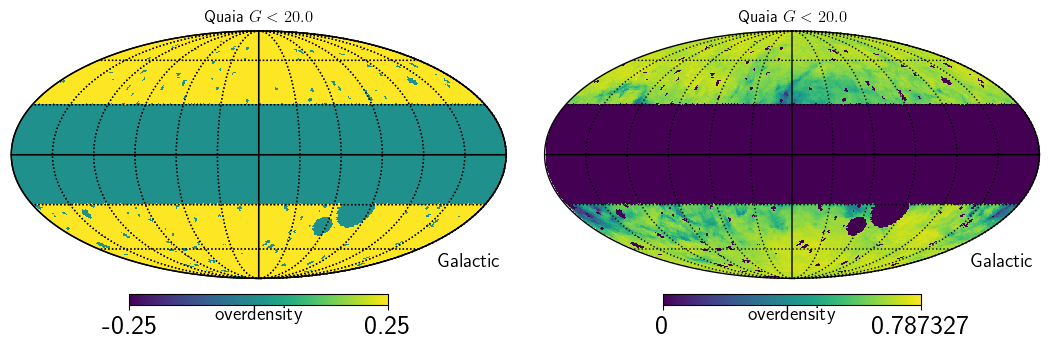

In [37]:
fig = plt.figure(figsize=(16,3))
hp.mollview(mask_b, coord=['C','G'], min=-0.25, max=0.25, badcolor='w', fig=fig, sub=(1,3,1),
            unit='overdensity', title=rf'Quaia $G<{d.maglim}$')
hp.graticule()
hp.mollview(mask, coord=['C','G'], min=0, max=np.max(mask), badcolor='w', fig=fig, sub=(1,3,2),
            unit='overdensity', title=rf'Quaia $G<{d.maglim}$')
hp.graticule()

/tmp/ipykernel_24153/2081258374.py:7: RuntimeWarning: invalid value encountered in divide
  hp.mollview(nmap/mask, coord=['C','G'],


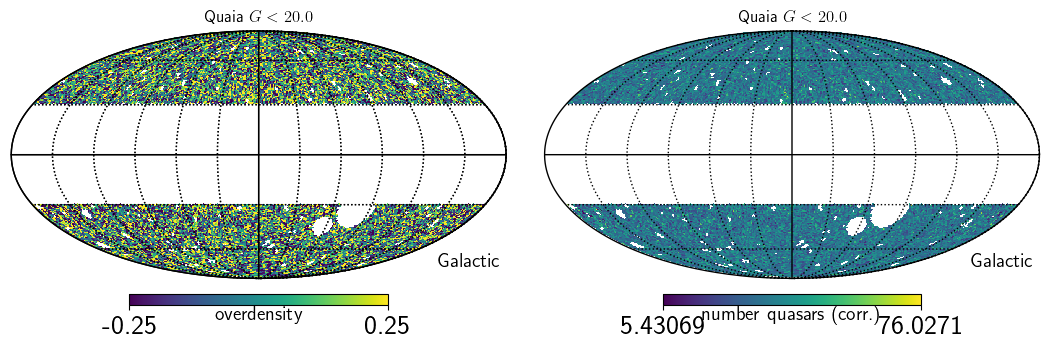

In [38]:
fig = plt.figure(figsize=(16,3))
map_masked = delta*mask_b
map_masked[map_masked==0] = hp.UNSEEN
hp.mollview(map_masked, coord=['C','G'], min=-0.25, max=0.25, badcolor='w', fig=fig, sub=(1,3,1),
            unit='overdensity', title=rf'Quaia $G<{d.maglim}$')
hp.graticule()
hp.mollview(nmap/mask, coord=['C','G'], 
            #min=-0.25, max=0.25, 
            badcolor='w', fig=fig, sub=(1,3,2),
            unit='number quasars (corr.)', title=rf'Quaia $G<{d.maglim}$')
hp.graticule()

Delta and map_quaia should both have been corrected by the selfunc

In [39]:
f_quaia = nmt.NmtField(mask, [map_quaia], n_iter=0)

In [40]:
f_cat = nmt.NmtField(mask, [delta], n_iter=0)

Set up C_ell calculator and compute

In [41]:
# Calculator
def get_cl(f1, f2, b, pnl=None):
    pcl = nmt.compute_coupled_cell(f1, f2)
    w = nmt.NmtWorkspace()
    w.compute_coupling_matrix(f1, f2, b)
    cl = w.decouple_cell(pcl)
    if pnl is not None:
        nl = w.decouple_cell(pnl)
        cl -= nl
    else:
        nl = np.zeros_like(cl)
    wins = w.get_bandpower_windows()
    return cl, nl, w, wins.squeeze()

In [42]:
cl, nl, w, Bbl = get_cl(f_quaia, f_quaia, b, pnl=nl_coupled)
#cl, nl, w, Bbl = get_cl(f_quaia, f_quaia, pnl=None)
print(cl)

[[ 2.21611321e-04  7.15786375e-05 -4.67919221e-05 -1.11607424e-05
   6.29594180e-05  5.38456308e-05  9.37227048e-06  1.17590913e-06]]


In [43]:
cl_full = nmt.compute_full_master(f_quaia, f_quaia, b)
print(cl_full)

[[ 2.34116546e-04  8.57832789e-05 -3.38732089e-05  1.47361174e-06
   7.45845937e-05  6.55077059e-05  2.63727580e-05  1.81335204e-05]]


In [44]:
cl_cat, nl_cat, w_cat, Bbl_cat = get_cl(f_cat, f_cat, b, pnl=nl_coupled)
#cl, nl, w, Bbl = get_cl(f_quaia, f_quaia, pnl=None)
print(cl_cat)

[[ 2.27229439e-04  2.05131791e-06 -4.45032250e-05 -5.86303078e-06
   5.82113141e-05  2.92107351e-05  1.34658950e-05  7.37685127e-06]]


Covs

In [45]:
cws = {}

def get_cov(f1, f2, f3, f4, w12, w34):
    fs = [f1, f2, f3, f4]
    ms = [f.get_mask() for f in fs]
    # Compute all pseudo-Cls
    cls = np.array([[nmt.compute_coupled_cell(fs[i], fs[j])/np.mean(ms[i]*ms[j])
                     for i in range(4)] for j in range(4)])
    cw = nmt.NmtCovarianceWorkspace()
    cw.compute_coupling_coefficients(f1, f2, f3, f4)
    cv = nmt.gaussian_covariance(cw, 0, 0, 0, 0, cls[0, 2], cls[0, 3], cls[1, 2], cls[1, 3], w12, wb=w34)
    return cv

In [46]:
f = f_quaia
cv = get_cov(f, f, f, f, w, w)

In [47]:
cv.shape

(8, 8)

In [48]:
np.sqrt(np.diag(cv))

array([2.28991349e-04, 6.73464420e-05, 4.49923936e-05, 2.47567471e-05,
       4.15978293e-05, 3.51633603e-05, 1.91555090e-05, 1.42098250e-05])

In [49]:
Cells_quaia_std[1:]

array([3.91612631e-05, 2.92938432e-05, 1.25074157e-05, 1.82484418e-05,
       2.33241365e-05, 1.98003192e-05, 1.40538246e-05, 1.48740955e-05])

Plottt

[1 2 3 4 5 6 7 8] [1.03076167e-04 6.07198246e-05 1.85652836e-05 2.35744866e-05
 4.44677877e-05 5.50685988e-05 2.46599848e-05 3.24939047e-05]


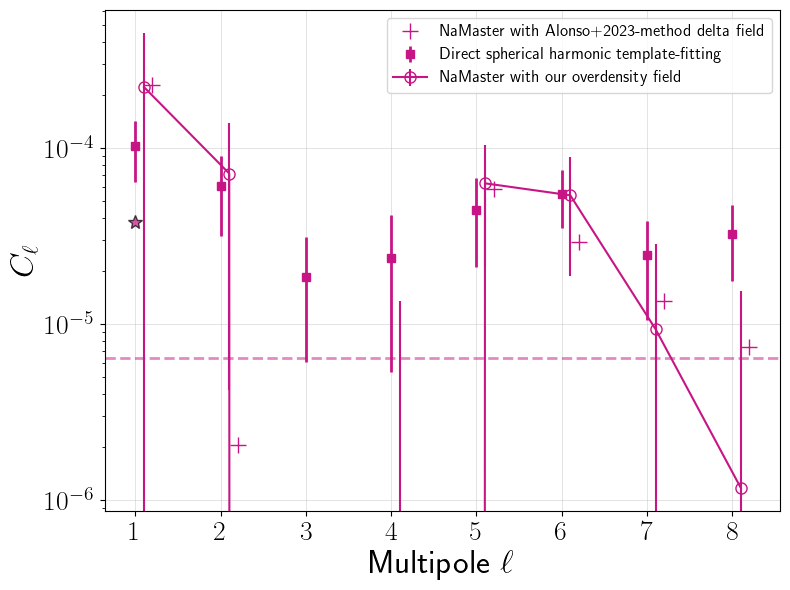

In [50]:
# plottt
#  (Cell functions output C_0, but start with C_1 since we're fitting overdensities)
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
#kwargs = dict(ls='None', ms=6, alpha=0.6, capsize=2, lw=lw)
kwargs = dict(ls='None', ms=6, alpha=1, lw=lw)


# ax.plot(leff+0.1, cl_full[0], color=color_quaia, marker='o', markersize=8, markerfacecolor='None',
#         ls='None', label='Quaia / namaster')

print(ells[1:], Cells_quaia[1:])
ax.errorbar(ells[1:], Cells_quaia[1:], yerr=Cells_quaia_std[1:],
            c=color_quaia, label=r'Direct spherical harmonic template-fitting', marker='s', **kwargs)

# ax.plot(leff+0.1, cl[0], color=color_quaia, marker='o', markersize=8, markerfacecolor='None',
#         ls='None', label='NaMaster with our overdensity field')
ax.errorbar(leff+0.1, cl[0], yerr=np.sqrt(np.diag(cv)),
            color=color_quaia, marker='o', markersize=8, markerfacecolor='None',
            #ls='None', 
            label='NaMaster with our overdensity field')


ax.plot(leff+0.2, cl_cat[0], color=color_quaia, marker='+', markersize=12, #markerfacecolor='None',
        ls='None', lw=2, label='NaMaster with Alonso+2023-method delta field')


# expected dipole amplitude
kwargs = dict(marker='*', ms=10, mec='k', alpha=0.7)
ax.plot(1, expected_C1_quaia, c=color_quaia, **kwargs, lw=lw)
# manual label
marker = mpl.lines.Line2D([0],[0], c='None', label='Expected from CMB', **kwargs)

# shot noise estimates
kwargs = dict(ls='--', alpha=0.5, lw=lw)
ax.axhline(noise_quaia_Cell, c=color_quaia, **kwargs)
#ax.axhline(noise_quaia_cross, c=color_quaia, **kwargs)
# manual label
line = mpl.lines.Line2D([0], [0], label='Shot noise', c='k', **kwargs)

# model + shot noise
#ax.plot(ells_mod, Cells_mod + noise_quaia_Cell, c=color_quaia, label='Model + shot noise', alpha=0.5)

# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([marker, line])

ax.semilogy()
ax.grid(alpha=0.5, lw=lw_grid)
#ax.set_xlim(ells[1:][0] - 0.5, ells[1:][-1] + 0.5)
#ax.set_ylim(2e-6, 3e-4)
ax.set_xlabel(r'Multipole $\ell$')
#ax.set_xticks(ells[1:])
ax.set_ylabel(r'$C_\ell$')
# ax.set_title(r'Angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
#ax.legend(loc=1, handles=handles)
ax.legend(loc=1, fontsize=12)

TODO 
- use verbose=True in abby's functions
- understand delta vs overdensity map, looking at abby's code

# Dependence on lmax

In [ ]:
l_max_arr = np.arange(1, max_ell+1)
cl_arr_lmaxdep = []
cl_nonl_arr_lmaxdep = []
leff_arr_lmaxdep = []
for l_max in l_max_arr:

    # Bins
    ells_nmt = np.arange(1, l_max+1)
    bpws = np.arange(len(ells_nmt))
    weights = np.ones(len(ells_nmt))/len(ells_nmt)
    b = nmt.NmtBin(d.NSIDE, ells=ells_nmt, bpws=bpws, weights=weights)
    leff = b.get_effective_ells()
    
    cl, nl, w, Bbl = get_cl(f_quaia, f_quaia, b, pnl=nl_coupled)
    
    cl_nonl, nl_nonl, w_nonl, Bbl_nonl = get_cl(f_quaia, f_quaia, b, pnl=None)
    
    cl_arr_lmaxdep.append(cl)
    cl_nonl_arr_lmaxdep.append(cl_nonl)
    leff_arr_lmaxdep.append(leff)

In [ ]:
# plottt
#  (Cell functions output C_0, but start with C_1 since we're fitting overdensities)
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
#kwargs = dict(ls='None', ms=6, alpha=0.6, capsize=2, lw=lw)
kwargs = dict(ls='None', ms=6, alpha=1, lw=lw)

ax.errorbar(ells[1:], Cells_quaia[1:], yerr=Cells_quaia_std[1:],
                c=color_quaia, label='Quaia direct',
                marker='s', **kwargs)

for i in range(len(l_max_arr)):

    ax.errorbar(leff_arr_lmaxdep[i]+0.1, cl_arr_lmaxdep[i][0], #yerr=np.sqrt(np.diag(cv)),
                color=color_quaia, marker='o', markersize=8, markerfacecolor='None',
                #ls='None', 
                label=rf'Namaster, $lmax={l_max_arr[i]}$',
                alpha=l_max_arr[i]/10)

#     ax.plot(leff+0.2, cl_cat[0], color=color_quaia, marker='+', markersize=12, #markerfacecolor='None',
#             ls='None', lw=2, label='NaMaster with Alonso+2023-method delta field')


# expected dipole amplitude
kwargs = dict(marker='*', ms=10, mec='k', alpha=0.7)
ax.plot(1, expected_C1_quaia, c=color_quaia, **kwargs, lw=lw)
# manual label
marker = mpl.lines.Line2D([0],[0], c='None', label='Expected from CMB', **kwargs)

# shot noise estimates
kwargs = dict(ls='--', alpha=0.5, lw=lw)
ax.axhline(noise_quaia_Cell, c=color_quaia, **kwargs)
#ax.axhline(noise_quaia_cross, c=color_quaia, **kwargs)
# manual label
line = mpl.lines.Line2D([0], [0], label='Shot noise', c='k', **kwargs)

# model + shot noise
#ax.plot(ells_mod, Cells_mod + noise_quaia_Cell, c=color_quaia, label='Model + shot noise', alpha=0.5)

# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([marker, line])

ax.semilogy()
ax.grid(alpha=0.5, lw=lw_grid)
#ax.set_xlim(ells[1:][0] - 0.5, ells[1:][-1] + 0.5)
#ax.set_ylim(2e-6, 3e-4)
ax.set_xlabel(r'Multipole $\ell$')
#ax.set_xticks(ells[1:])
ax.set_ylabel(r'$C_\ell$')
# ax.set_title(r'Angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
#ax.legend(loc=1, handles=handles)
ax.legend(loc='upper right', fontsize=10)

Very little dependence on l_max! Only notable one is l=4 which sometimes goes negative and sometimes is just small.

In [ ]:
# plottt
#  (Cell functions output C_0, but start with C_1 since we're fitting overdensities)
fig, ax = plt.subplots(figsize=(8,6), tight_layout=True)
fig.suptitle('No NL correction')
#kwargs = dict(ls='None', ms=6, alpha=0.6, capsize=2, lw=lw)
kwargs = dict(ls='None', ms=6, alpha=1, lw=lw)

ax.errorbar(ells[1:], Cells_quaia[1:], yerr=Cells_quaia_std[1:],
                c=color_quaia, label='Quaia direct',
                marker='s', **kwargs)

for i in range(len(l_max_arr)):

    ax.errorbar(leff_arr_lmaxdep[i]+0.1, cl_nonl_arr_lmaxdep[i][0], #yerr=np.sqrt(np.diag(cv)),
                color=color_quaia, marker='o', markersize=8, markerfacecolor='None',
                #ls='None', 
                label=rf'Namaster, $lmax={l_max_arr[i]}$',
                alpha=l_max_arr[i]/10)

#     ax.plot(leff+0.2, cl_cat[0], color=color_quaia, marker='+', markersize=12, #markerfacecolor='None',
#             ls='None', lw=2, label='NaMaster with Alonso+2023-method delta field')


# expected dipole amplitude
kwargs = dict(marker='*', ms=10, mec='k', alpha=0.7)
ax.plot(1, expected_C1_quaia, c=color_quaia, **kwargs, lw=lw)
# manual label
marker = mpl.lines.Line2D([0],[0], c='None', label='Expected from CMB', **kwargs)

# shot noise estimates
kwargs = dict(ls='--', alpha=0.5, lw=lw)
ax.axhline(noise_quaia_Cell, c=color_quaia, **kwargs)
#ax.axhline(noise_quaia_cross, c=color_quaia, **kwargs)
# manual label
line = mpl.lines.Line2D([0], [0], label='Shot noise', c='k', **kwargs)

# model + shot noise
#ax.plot(ells_mod, Cells_mod + noise_quaia_Cell, c=color_quaia, label='Model + shot noise', alpha=0.5)

# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([marker, line])

ax.semilogy()
ax.grid(alpha=0.5, lw=lw_grid)
#ax.set_xlim(ells[1:][0] - 0.5, ells[1:][-1] + 0.5)
#ax.set_ylim(2e-6, 3e-4)
ax.set_xlabel(r'Multipole $\ell$')
#ax.set_xticks(ells[1:])
ax.set_ylabel(r'$C_\ell$')
# ax.set_title(r'Angular power $C_\ell$, $0\leq\ell\leq$'f'{max_ell}')
#ax.legend(loc=1, handles=handles)
ax.legend(loc='upper right', fontsize=10)

If we don't correct for the NL term, we see more differences, but still not too much (not nearly as much as in direct fitting case).